In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from module.dataload import load_data
from module.dl_model import ChurnPredictionModel
from module.dl_train import fit
from module.dl_test import metrics

1. 데이터 로드 및 전처리:    
데이터를 불러오고, 결측치를 제거한 후 타겟 값을 인코딩하고 표준화하여 학습 및 평가 데이터셋으로 분리합니다.

2. 모델 정의:    
드롭아웃을 각 은닉층에 추가하여 과적합을 방지하고, 모델의 일반화 성능을 높입니다.    
ReLU 활성화 함수로 비선형성을 추가하여 복잡한 패턴을 학습할 수 있게 합니다.

3. 옵티마이저 및 스케줄러 설정:    
Adam 옵티마이저로 학습 속도를 개선하고, 자동으로 학습률을 조절합니다.    
CosineAnnealingWarmRestarts를 사용하여 학습률을 점진적으로 감소시키면서 주기적으로 리셋하여, 최적점을 찾기 쉽도록 합니다.

4. 학습 과정:    
optimizer.zero_grad()로 각 배치마다 그래디언트를 초기화하고, loss.backward()로 역전파를 수행한 후 optimizer.step()으로 모델 파라미터를 업데이트합니다.     
매 에포크마다 학습 손실과 정확도를 기록합니다.    
scheduler.step()을 통해 매 epoch마다 학습률을 조정하여 과적합 방지

In [ ]:
# dataload로 ml/dl 병합합
# %%writefile module/dl_data.py
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# 데이터 로드 및 전처리 함수
def load_set_dataloader(file_path, batch_size):
    # 데이터 로드
    data = pd.read_csv(file_path)
    # 입력 데이터(X)와 타겟(y) 분리
    X = data.drop(["ID", "label"], axis=1)
    y = np.array(data["label"])
    y = y.reshape(-1, 1)
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=0
    )

    # 데이터 표준화
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # PyTorch 텐서로 변환 후 TensorDataset과 DataLoader 생성 (배치 학습 적용)
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    )

    test_dataset = TensorDataset(

        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=2860)
    return train_loader, test_loader, y_test

Writing module/dl_data.py


In [ ]:
# 데이터 로드 및 분리 - 이상치 제거 X
train_loader, test_loader, y_test = load_data(
    "data/preprocessed.csv", learning_type="dl", batch_size=64
)
np.savetxt("data/y_test.csv", y_test)
torch.save(test_loader, "data/test_loader.pth")

In [ ]:
# 데이터 로드 및 분리 - 이상치 제거
train_loader, test_loader, y_test = load_data(
    "data/preprocessed_drives_outlier.csv", learning_type="dl", batch_size=64
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
%%writefile module/dl_model.py
import torch
import torch.nn as nn
# 모델
class ChurnPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 은닉층과 배치 정규화, 드롭아웃 추가
        self.fc1 = nn.Linear(12, 128)  # 첫 번째 은닉층
        self.bn1 = nn.BatchNorm1d(128)  # 첫 번째 배치 정규화
        self.fc2 = nn.Linear(128, 64)  # 두 번째 은닉층
        self.bn2 = nn.BatchNorm1d(64)  # 두 번째 배치 정규화
        self.fc3 = nn.Linear(64, 32)  # 세 번째 은닉층
        self.bn3 = nn.BatchNorm1d(32)  # 세 번째 배치 정규화
        self.fc4 = nn.Linear(32, 1)  # 출력층

        # 활성화 함수와 드롭아웃 설정
        self.relu = nn.ReLU()  # 활성화 함수
        self.dropout = nn.Dropout(0.35)  # 드롭아웃 확률: 35%

    def forward(self, x):
        # 각 은닉층 통과 시 배치 정규화 및 드롭아웃 적용
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))  # 이진 분류를 위한 sigmoid 활성화 함수
        return x

In [3]:
# 모델, 손실 함수, 옵티마이저, LR스케줄러 정의
model = ChurnPredictionModel()
loss_fn = nn.BCELoss()  # 이진 분류에 적합한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=0.00001)

num_epochs = 100
patience = 20  # 조기 종료를 위한 patience 값

In [5]:
# 이상치 제거 X
save_path = "model/dl_model.pt"  # 최적 모델 저장 경로

In [ ]:
# 이상치 제거
save_path = "model/dl_model_outlier.pth"  # 최적 모델 저장 경로

In [8]:
%%writefile module/dl_train.py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time

# train 함수에 들어가는 valid 부분
def valid(dataloader, model, loss_fn, device="cpu"):
    model.to(device)
    model.eval()
    loss = acc = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)  # positive일 확률
            loss += loss_fn(pred, y).item()
            #  이진 분류에서 accuracy
            acc += torch.sum((pred > 0.5).type(torch.int32) == y).item()
        loss /= len(dataloader)
        acc /= len(dataloader.dataset)
    return loss, acc

def train(dataloader, model, loss_fn, optimizer, scheduler, device="cpu"):
    model.train()
    train_loss = 0
    # 학습률 조정 스케줄러: CosineAnnealingWarmRestarts를 사용하여 학습률을 주기적으로 리셋
    scheduler = scheduler

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        # 손실 계산 및 역전파
        loss = loss_fn(pred, y)
        loss.backward()
        # 파라미터 업데이트
        optimizer.step()
        # 파라미터 초기화
        optimizer.zero_grad()
        train_loss += loss.item()
    # LR 변경 요청
    scheduler.step()
    # loss 계산 및 list 추가
    train_loss /= len(dataloader)
    return train_loss

# 학습
def fit(num_epochs, train_loader, valid_loader, model, loss_fn, optimizer, scheduler, save_path, patience, device="cpu"):
    # 손실과 정확도 기록용 리스트 초기화
    train_losses = []
    valid_losses = []
    valid_acces = []
    best_score = torch.inf  # 성능 개선 기준 초기값
    trigger_count = 0  # 개선이 없을 때 증가하는 카운트

    s = time.time()  # 학습 시작 시간 기록
    for epoch in range(num_epochs):
        # 모델 학습
        train_loss = train(train_loader, model, loss_fn, optimizer, scheduler)
        # 모델 검증
        valid_loss, valid_acc = valid(valid_loader, model, loss_fn)
        
        # loss 계산 및 list 추가
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_acces.append(valid_acc)

        # Best Score 업데이트 및 조기 종료 체크
        if valid_loss < best_score:
            print(
                f"Epoch [{epoch+1:3d}/{num_epochs}], >>>>> Loss Improved from {best_score:.4f} to {valid_loss:.4f}. Saving Model."
            )
            best_score = valid_loss
            torch.save(model, save_path)
            trigger_count = 0  # 성능 개선 시 초기화
        else:
            trigger_count += 1
            if trigger_count >= patience:
                print(
                    f"Early stopping at epoch {epoch+1:3d}. No improvement for {patience} epochs."
                )
                break

        print(
            f"Epoch [{epoch+1:3d}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}"
        )

    e = time.time()
    training_time = e - s
    print(f"\nTotal Training Time: {training_time:.2f} seconds")
    return train_losses, valid_losses, valid_acces

Overwriting module/dl_train.py


In [ ]:
train_losses, valid_losses, valid_acces = fit(
    num_epochs,
    train_loader,
    test_loader,
    model,
    loss_fn,
    optimizer,
    scheduler,
    save_path,
    patience,
    device="cpu",
)

Epoch [  1/100], >>>>> Loss Improved from inf to 0.4236. Saving Model.
Epoch [  1/100], Train Loss: 0.4718, Valid Loss: 0.4236, Valid Acc: 0.8224
Epoch [  2/100], >>>>> Loss Improved from 0.4236 to 0.4194. Saving Model.
Epoch [  2/100], Train Loss: 0.4234, Valid Loss: 0.4194, Valid Acc: 0.8231
Epoch [  3/100], >>>>> Loss Improved from 0.4194 to 0.4175. Saving Model.
Epoch [  3/100], Train Loss: 0.4180, Valid Loss: 0.4175, Valid Acc: 0.8227
Epoch [  4/100], >>>>> Loss Improved from 0.4175 to 0.4168. Saving Model.
Epoch [  4/100], Train Loss: 0.4171, Valid Loss: 0.4168, Valid Acc: 0.8224
Epoch [  5/100], >>>>> Loss Improved from 0.4168 to 0.4168. Saving Model.
Epoch [  5/100], Train Loss: 0.4175, Valid Loss: 0.4168, Valid Acc: 0.8227
Epoch [  6/100], Train Loss: 0.4165, Valid Loss: 0.4174, Valid Acc: 0.8227
Epoch [  7/100], >>>>> Loss Improved from 0.4168 to 0.4150. Saving Model.
Epoch [  7/100], Train Loss: 0.4141, Valid Loss: 0.4150, Valid Acc: 0.8227
Epoch [  8/100], Train Loss: 0.413

In [4]:
# LR 조정
from torch.optim.lr_scheduler import (
    StepLR,
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
)

# StepLR
s_sch = StepLR(optimizer, step_size=30, gamma=0.5)
# CosineAnnealingLR
c_sch = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)
# CosineAnnealingWarmRestarts
cw_sch = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=0.00001)

In [5]:
save_path = "model/dl_model_lr.pth"

In [ ]:
train_losses, valid_losses, valid_acces = fit(
    num_epochs,
    train_loader,
    test_loader,
    model,
    loss_fn,
    optimizer,
    s_sch,
    save_path,
    patience,
    device="cpu",
)

Epoch [  1/100], >>>>> Loss Improved from inf to 0.4196. Saving Model.
Epoch [  1/100], Train Loss: 0.4896, Valid Loss: 0.4196, Valid Acc: 0.8241
Epoch [  2/100], >>>>> Loss Improved from 0.4196 to 0.4153. Saving Model.
Epoch [  2/100], Train Loss: 0.4224, Valid Loss: 0.4153, Valid Acc: 0.8227
Epoch [  3/100], Train Loss: 0.4183, Valid Loss: 0.4164, Valid Acc: 0.8227
Epoch [  4/100], >>>>> Loss Improved from 0.4153 to 0.4148. Saving Model.
Epoch [  4/100], Train Loss: 0.4182, Valid Loss: 0.4148, Valid Acc: 0.8227
Epoch [  5/100], Train Loss: 0.4155, Valid Loss: 0.4148, Valid Acc: 0.8227
Epoch [  6/100], >>>>> Loss Improved from 0.4148 to 0.4145. Saving Model.
Epoch [  6/100], Train Loss: 0.4143, Valid Loss: 0.4145, Valid Acc: 0.8227
Epoch [  7/100], >>>>> Loss Improved from 0.4145 to 0.4135. Saving Model.
Epoch [  7/100], Train Loss: 0.4128, Valid Loss: 0.4135, Valid Acc: 0.8227
Epoch [  8/100], Train Loss: 0.4145, Valid Loss: 0.4140, Valid Acc: 0.8227
Epoch [  9/100], Train Loss: 0.41

In [7]:
train_losses, valid_losses, valid_acces = fit(
    num_epochs,
    train_loader,
    test_loader,
    model,
    loss_fn,
    optimizer,
    c_sch,
    save_path,
    patience,
    device="cpu",
)

Epoch [  1/100], >>>>> Loss Improved from inf to 0.4124. Saving Model.
Epoch [  1/100], Train Loss: 0.4054, Valid Loss: 0.4124, Valid Acc: 0.8248
Epoch [  2/100], Train Loss: 0.4020, Valid Loss: 0.4125, Valid Acc: 0.8238
Epoch [  3/100], Train Loss: 0.4022, Valid Loss: 0.4131, Valid Acc: 0.8248
Epoch [  4/100], >>>>> Loss Improved from 0.4124 to 0.4123. Saving Model.
Epoch [  4/100], Train Loss: 0.4052, Valid Loss: 0.4123, Valid Acc: 0.8252
Epoch [  5/100], Train Loss: 0.4058, Valid Loss: 0.4126, Valid Acc: 0.8238
Epoch [  6/100], Train Loss: 0.4026, Valid Loss: 0.4124, Valid Acc: 0.8245
Epoch [  7/100], Train Loss: 0.4013, Valid Loss: 0.4126, Valid Acc: 0.8248
Epoch [  8/100], Train Loss: 0.4027, Valid Loss: 0.4125, Valid Acc: 0.8245
Epoch [  9/100], Train Loss: 0.4030, Valid Loss: 0.4125, Valid Acc: 0.8245
Epoch [ 10/100], Train Loss: 0.4029, Valid Loss: 0.4129, Valid Acc: 0.8248
Epoch [ 11/100], Train Loss: 0.4031, Valid Loss: 0.4125, Valid Acc: 0.8255
Epoch [ 12/100], Train Loss: 0

In [ ]:
%%writefile module/dl_test.py
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    roc_curve,
    auc,
    precision_recall_curve,
)


def test(test_loader, y_test, best_model, device="cpu"):
    # load best model
    best_model.to(device)
    best_model.eval()
    # 모델 평가
    y_pred_list = []
    y_prob_list = []
    valid_acc = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            prob_test = best_model(X_batch)
            pred_test = prob_test.round()
            valid_acc += torch.sum(
                (pred_test < 0.5).type(torch.int32) == y_batch
            ).item()
            y_pred_list.append(pred_test)
            y_prob_list.append(prob_test)
        y_pred_list = np.concatenate(y_pred_list)
        y_prob_list = np.concatenate(y_prob_list)
    return y_pred_list, y_prob_list

def metrics(test_loader_path, y_test_path, model_path, device="cpu"):
    test_loader = torch.load(test_loader_path)
    y_test = np.loadtxt(y_test_path)
    best_model = torch.load(model_path, map_location="cpu")
    y_pred_list, y_prob_list = test(test_loader, y_test, best_model, device="cpu")
    metrics = {}
    # 성능 평가 지표 계산
    accuracy = accuracy_score(y_test, y_pred_list)
    recall = recall_score(y_test, y_pred_list)
    precision = precision_score(y_test, y_pred_list)
    f1 = f1_score(y_test, y_pred_list)
    metrics["metric"] = ["Accuracy", "Recall", "Precision", "F1 Score"]
    metrics["value"] = [accuracy, recall, precision, f1]
    # roc curve
    fpr, tpr, _ = roc_curve(y_test, y_prob_list)
    roc_auc = auc(fpr, tpr)
    metrics["fpr"] = fpr
    metrics["tpr"] = tpr
    metrics["roc_auc"] = roc_auc

    # precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob_list)
    metrics["precision"] = precision
    metrics["recall"] = recall

    return metrics, y_test, y_pred_list

Overwriting module/dl_test.py


In [ ]:
save_path = "model/dl_model.pt"
test_loader_path = "data/test_loader.pth"


y_test_path = "data/y_test.csv"


metrics, y_test, y_pred_list = metrics(
    test_loader_path, y_test_path, save_path, device="cpu"
)

c:\SKN06class\team_project\2nd_team_project\module\dl_test.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_loader = torch.load(test_loader_path)
c:\SKN06class\team

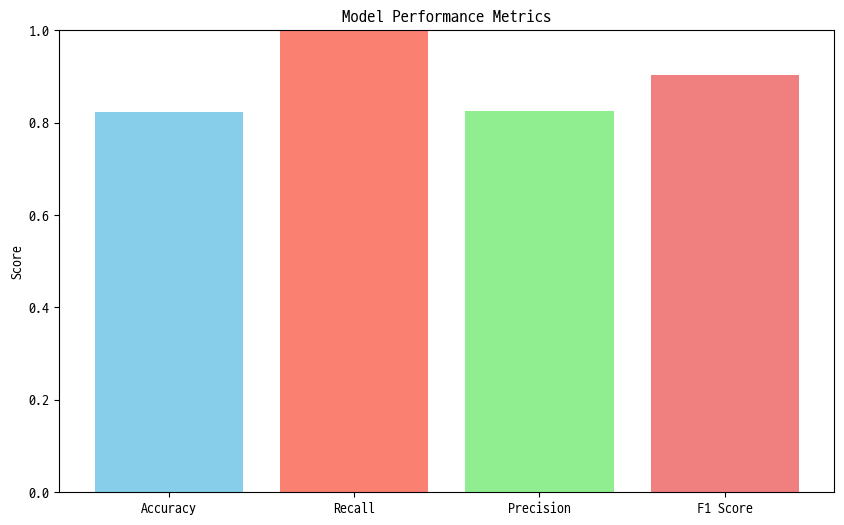

In [9]:
# 정확도, 재현율, 정밀도, F1 점수 시각화
metric = metrics["metric"]
values = metrics["value"]

plt.figure(figsize=(10, 6))
plt.bar(metric, values, color=["skyblue", "salmon", "lightgreen", "lightcoral"])
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()

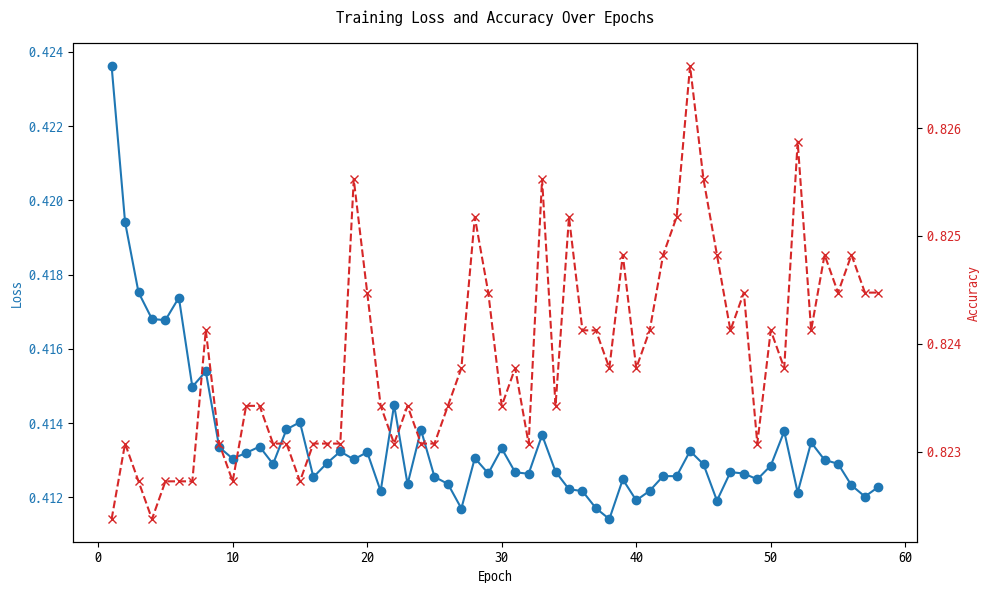

In [10]:
# 이중 y축 그래프: 학습 손실 및 정확도 변화 추세
fig, ax1 = plt.subplots(figsize=(10, 6))

# 손실 값 (왼쪽 y축)
color = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color)
ax1.plot(
    range(1, len(train_losses) + 1),
    valid_losses,
    color=color,
    marker="o",
    label="Train Loss",
)
ax1.tick_params(axis="y", labelcolor=color)

# 정확도 값 (오른쪽 y축)
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Accuracy", color=color)
ax2.plot(
    range(1, len(valid_acces) + 1),
    valid_acces,
    color=color,
    marker="x",
    linestyle="--",
    label="valid Accuracy",
)
ax2.tick_params(axis="y", labelcolor=color)

fig.suptitle("Training Loss and Accuracy Over Epochs")
fig.tight_layout()
plt.show()

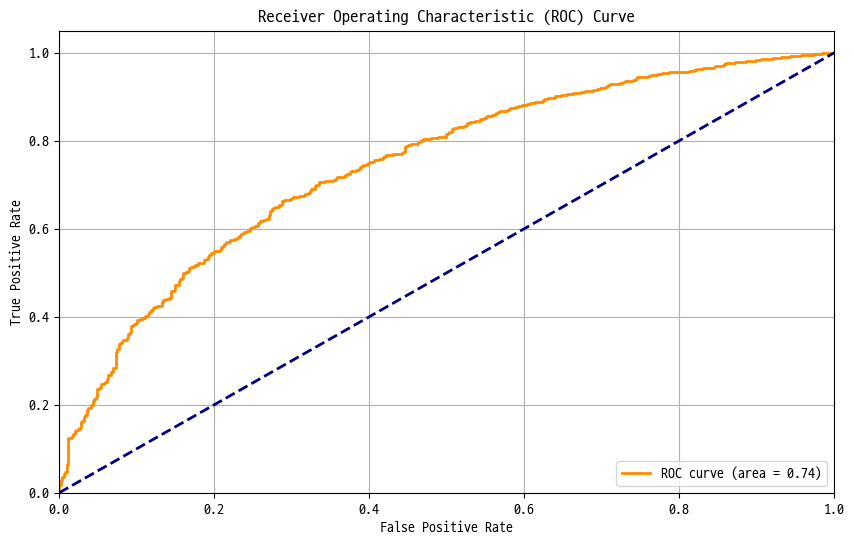

In [11]:
# ROC 곡선 및 AUC 계산
fpr = metrics["fpr"]
tpr = metrics["tpr"]
roc_auc = metrics["roc_auc"]

# ROC 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

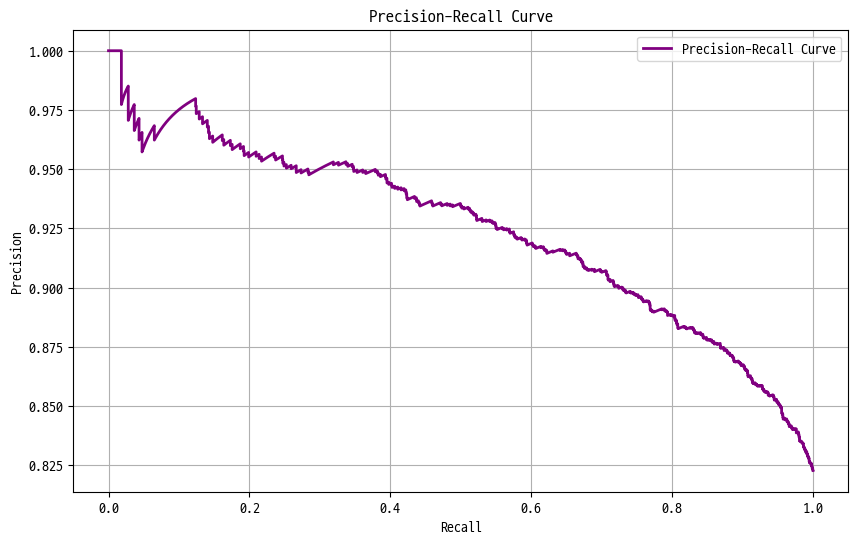

In [12]:
# Precision-Recall 곡선
precision = metrics["precision"]
recall = metrics["recall"]

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color="purple", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid()
plt.show()

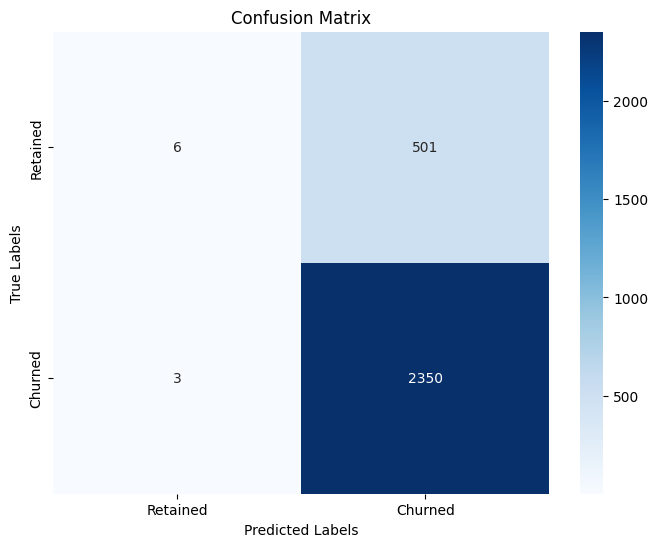

In [6]:
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred_list)


# 히트맵으로 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Retained", "Churned"],
    yticklabels=["Retained", "Churned"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
report = classification_report(y_test, y_pred_list)
print(report)

              precision    recall  f1-score   support

         0.0       0.67      0.01      0.02       507
         1.0       0.82      1.00      0.90      2353

    accuracy                           0.82      2860
   macro avg       0.75      0.51      0.46      2860
weighted avg       0.80      0.82      0.75      2860

